In [4]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# sys.path.append('../src')
# import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Modelling

In [5]:
from fastai.text.all import *

In [6]:
path = Path('../')

In [16]:
folder = 'just_ndcs'

In [7]:
files = get_text_files(path, folders = [folder])

In [8]:
len(files)

121690

In [9]:
txts = L(o.open().read().split(' ') for o in files)

In [10]:
len(txts)

121690

In [11]:
lens = [len(t) for t in txts]

In [17]:
np.mean(lens), np.median(lens), np.max(lens), np.min(lens)

(161.34843454679924, 29.0, 4309, 1)

In [13]:
counter = Counter(tok for pat in txts for tok in set(pat))

In [14]:
vocab = make_vocab(counter, min_freq=20)

In [18]:
dls = TextDataLoaders.from_folder(
    path / folder,
    valid_pct=.1,
    seed=None,
    text_vocab=vocab,
    is_lm=True,
    tok_tfm=None,
    seq_len=72,
    backwards=False,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None
)

In [19]:
learn = language_model_learner(
    dls=dls,
    arch=AWD_LSTM,
    drop_mult=1,
    pretrained=False,
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4),
        SaveModelCallback(monitor='valid_loss',fname='ndc_model_20220923')
    ],
    metrics=[accuracy, Perplexity()]).to_fp16()

In [22]:
dls.show_batch(max_n=2)

,text,text_
0,xxbos 00904643480 ttlc_30 00904671960 ttlc_60 61314063006 ttlc_gt180 xxunk xxrep xxunk 0 xxunk ttlc_15 00904671980 00904672580 ttlc_180 45802006003 ttlc_10 45802006003 ttlc_90 xxunk xxrep xxunk 0 xxunk ttlc_180 16729017217 67877019805 68382011214 ttlc_2 xxunk xxrep xxunk 0 xxunk ttlc_30 49483034010 ttlc_10 49483034010 ttlc_30 49483008010 ttlc_30 xxunk xxrep xxunk 0 xxunk ttlc_2 49483034010 ttlc_5 49483034010 ttlc_30 49483034010 ttlc_30 49483034010 ttlc_30 xxunk xxrep xxunk 0 xxunk ttlc_5 49483034010 ttlc_30 49483034010 ttlc_10 xxunk xxrep xxunk 0 xxunk ttlc_30,00904643480 ttlc_30 00904671960 ttlc_60 61314063006 ttlc_gt180 xxunk xxrep xxunk 0 xxunk ttlc_15 00904671980 00904672580 ttlc_180 45802006003 ttlc_10 45802006003 ttlc_90 xxunk xxrep xxunk 0 xxunk ttlc_180 16729017217 67877019805 68382011214 ttlc_2 xxunk xxrep xxunk 0 xxunk ttlc_30 49483034010 ttlc_10 49483034010 ttlc_30 49483008010 ttlc_30 xxunk xxrep xxunk 0 xxunk ttlc_2 49483034010 ttlc_5 49483034010 ttlc_30 49483034010 ttlc_30 49483034010 ttlc_30 xxunk xxrep xxunk 0 xxunk ttlc_5 49483034010 ttlc_30 49483034010 ttlc_10 xxunk xxrep xxunk 0 xxunk ttlc_30 49483034010
1,xxrep xxunk xxunk xxunk ttlc_2 00591024105 65162010350 ttlc_5 16729017601 ttlc_1 68382031910 ttlc_10 57237010099 ttlc_10 xxunk xxrep xxunk xxunk xxunk 68180098003 68462033090 ttlc_10 31722071390 ttlc_2 65162010350 ttlc_2 16729017601 ttlc_10 16729017601 68462033090 ttlc_1 00378001805 68180098003 68382031910 ttlc_1 16729017601 68462033090 ttlc_1 68180098003 ttlc_5 00591024105 xxunk xxrep xxunk xxunk xxunk ttlc_2 xxunk xxrep xxunk xxunk xxunk ttlc_1 42192015101 68180098003 ttlc_2 68462033090 ttlc_10 65162010350 ttlc_2 xxunk xxrep xxunk xxunk xxunk ttlc_1 xxunk xxrep xxunk xxunk xxunk ttlc_10,xxunk xxunk xxunk ttlc_2 00591024105 65162010350 ttlc_5 16729017601 ttlc_1 68382031910 ttlc_10 57237010099 ttlc_10 xxunk xxrep xxunk xxunk xxunk 68180098003 68462033090 ttlc_10 31722071390 ttlc_2 65162010350 ttlc_2 16729017601 ttlc_10 16729017601 68462033090 ttlc_1 00378001805 68180098003 68382031910 ttlc_1 16729017601 68462033090 ttlc_1 68180098003 ttlc_5 00591024105 xxunk xxrep xxunk xxunk xxunk ttlc_2 xxunk xxrep xxunk xxunk xxunk ttlc_1 42192015101 68180098003 ttlc_2 68462033090 ttlc_10 65162010350 ttlc_2 xxunk xxrep xxunk xxunk xxunk ttlc_1 xxunk xxrep xxunk xxunk xxunk ttlc_10 16729017601


In [23]:
len(vocab)

14152

In [24]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(14152, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(14152, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=14152, bias=True)
    (output_dp): RNNDropout()
  )
)

/home/bp/.local/share/virtualenvs/data-analytics-qWXImv-u/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00010964782268274575)

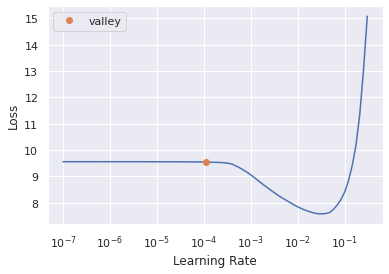

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(50, 10e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.913317,3.890378,0.410274,48.929367,17:21
1,3.600747,3.652501,0.429780,38.571007,17:16
2,3.422592,3.402328,0.438338,30.033953,17:17
3,3.077512,3.145263,0.448301,23.225788,17:17
4,2.951503,2.940205,0.460008,18.919725,17:22
5,2.807185,2.772980,0.470915,16.006269,17:18
6,2.635876,2.662339,0.478905,14.329767,17:19
7,2.610885,2.583760,0.484117,13.246857,17:19
8,2.514476,2.532968,0.486559,12.590824,17:18
9,2.476986,2.497094,0.488656,12.147140,17:18


Better model found at epoch 0 with valid_loss value: 3.8903777599334717.
Better model found at epoch 1 with valid_loss value: 3.652500867843628.
Better model found at epoch 2 with valid_loss value: 3.4023284912109375.
Better model found at epoch 3 with valid_loss value: 3.145263195037842.
Better model found at epoch 4 with valid_loss value: 2.9402050971984863.
Better model found at epoch 5 with valid_loss value: 2.7729804515838623.
Better model found at epoch 6 with valid_loss value: 2.662338972091675.
Better model found at epoch 7 with valid_loss value: 2.5837602615356445.
Better model found at epoch 8 with valid_loss value: 2.532968282699585.
Better model found at epoch 9 with valid_loss value: 2.497093677520752.
Better model found at epoch 10 with valid_loss value: 2.465897560119629.
Better model found at epoch 11 with valid_loss value: 2.433115005493164.
Better model found at epoch 12 with valid_loss value: 2.4128434658050537.
Better model found at epoch 13 with valid_loss value: 2

### Save model, encoder, and vocab

In [27]:
models_path = '/home/bp/data-analytics/models/'
file = models_path + 'ndc_lml_epoch_20_20220923.pkl'
file

'/home/bp/data-analytics/models/ndc_lml_epoch_20_20220923.pkl'

In [28]:
learn.save(file, with_opt=True, pickle_protocol=2)

Path('/home/bp/data-analytics/models/ndc_lml_epoch_20_20220923.pkl.pth')

In [29]:
file = models_path + 'ndc_lml_epoch_20_encoder_20220923'
learn.save_encoder(file)

In [30]:
file

'/home/bp/data-analytics/models/ndc_lml_epoch_20_encoder_20220923'

In [31]:
vocab_path = models_path + 'ndc_lml_epoch_20_vocab_20220923.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
vocab_path

'/home/bp/data-analytics/models/ndc_lml_epoch_20_vocab_20220923.pkl'

### Visualize Results

In [34]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(10952, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10952, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=10952, bias=True)
    (output_dp): RNNDropout()
  )
)

In [33]:
# with open('jsonb_object_agg_ndcoprietary_name___json.json', 'rb') as f:
#     ndc_lookup = json.load(f)
#     ndc_lookup = ndc_lookup[0]['jsonb_object_agg']
# with open('ndc_lookup.json', 'wb') as f:
#     pickle.dump(ndc_lookup, f)
with open('ndc_lookup.json', 'rb') as f:
    ndc_lookup = pickle.load(f)
ndc_lookup['00904643480']

'senna'

In [42]:
from torch.nn import functional as F

def get_normalized_embeddings():
    return F.normalize(learn.model[0].encoder.weight)

def most_similar(token, embs):
    if token[:2] == 'xx':
        return
#     idx = num.vocab.itos.index(token)
    idx = vocab.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}: {ndc_lookup[token]}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        if vocab[sim_idx][:2] == 'xx':
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}')
        else:
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}: {ndc_lookup[vocab[sim_idx]]}')
            

In [43]:
embeddings = get_normalized_embeddings()

In [47]:
for code in random.sample(vocab, 10):
    most_similar(code, embeddings)
    print('')

Similar to: 68462010630: ondansetron
0.99: 68462010530: ondansetron
0.98: 68462015813: ondansetron
0.98: 68382079101: acyclovir
0.98: 68382004001: promethazine hydrochloride
0.98: 68462018117: clotrimazole
0.98: 68462079817: triamcinolone acetonide
0.98: 68462018801: naproxen
0.98: 68180016613: vancomycin hydrochloride
0.98: 68462041820: lidocaine
0.97: 70710122501: amitriptyline hydrochloride

Similar to: 13668044101: celecoxib
0.98: 13668044201: celecoxib
0.98: 00713067653: triamcinolone acetonide
0.98: 13668044205: celecoxib
0.98: 00713063737: metronidazole
0.98: 13925015901: lidocaine hydrochloride
0.98: 00115174501: metaxalone
0.98: 13913001203: diclofenac potassium
0.98: 42858049340: buprenorphine
0.98: 00713022615: triamcinolone acetonide
0.98: 13811068930: tramadol hydrochloride

Similar to: 42806015901: hydroxyzine hydrochloride
0.99: 72888001405: cyclobenzaprine hydrochloride
0.99: 55111059660: memantine
0.99: 00093753656: anastrozole
0.99: 00006412102: human papillomavirus 9

KeyError: '96295012777'